In [1]:
%run '/home/gvolta/Desktop/Function/Useful/Def.ipynb'

Initialization done, Notebook was last run on: 04/07/2019


In [2]:
from pax import units, configuration
pax_config = configuration.load_configuration('XENON1T')['DEFAULT']
tpc_height = pax_config['tpc_length']
tpc_radius = pax_config['tpc_radius']

import hax
hax.init(experiment='XENON1T',
         pax_version_policy = '6.10.1',
         main_data_paths= ['/dali/lgrandi/xenon1t/processed/pax_v6.10.1'], 
         minitree_paths = [#'/home/gvolta/minitrees_test'
                           '/dali/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/project/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/dali/lgrandi/xenon1t/minitrees/pax_v6.10.1'
                          ],
         make_minitrees = True)

In [3]:
dali_path = '/dali/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'
project_path = '/project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'

### Opening data

In [4]:
file = project_path +  'data_cut_SR1_S1PL.pkl'
data = pd.read_pickle(file)

In [5]:
data_white = data.copy()
data = data[data['s1'] < 2e4]

## Data

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


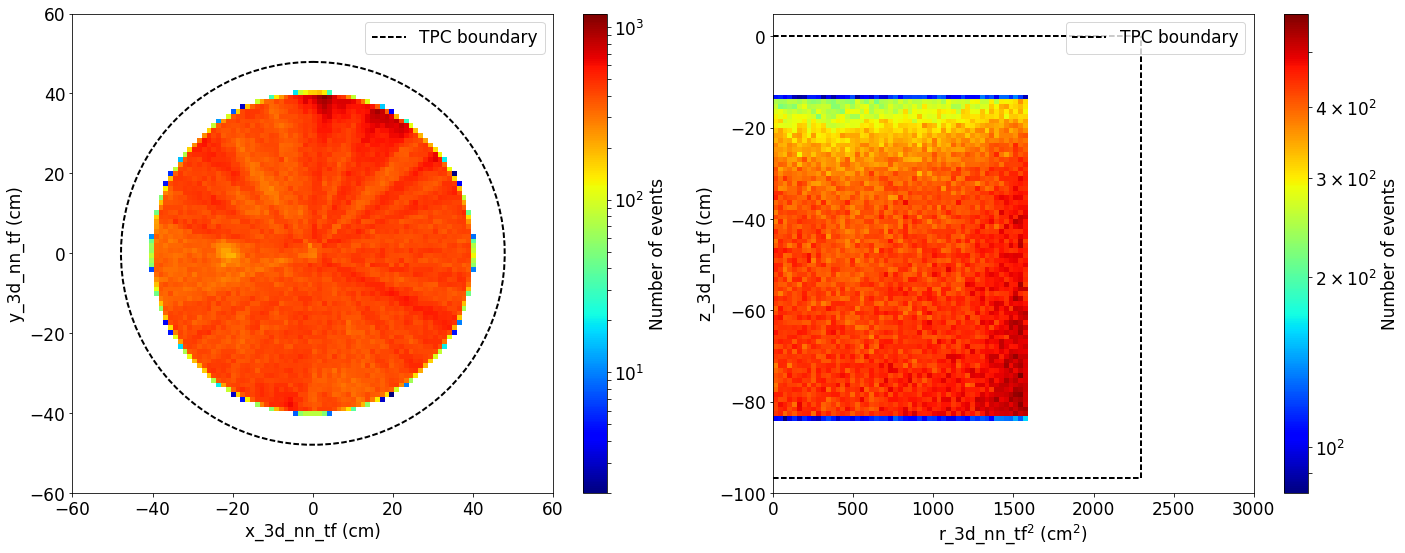

In [6]:
data_distribution(data_white, 'x_3d_nn_tf', 'y_3d_nn_tf', 'z_3d_nn_tf', 'r_3d_nn_tf', bins=[100,100])

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


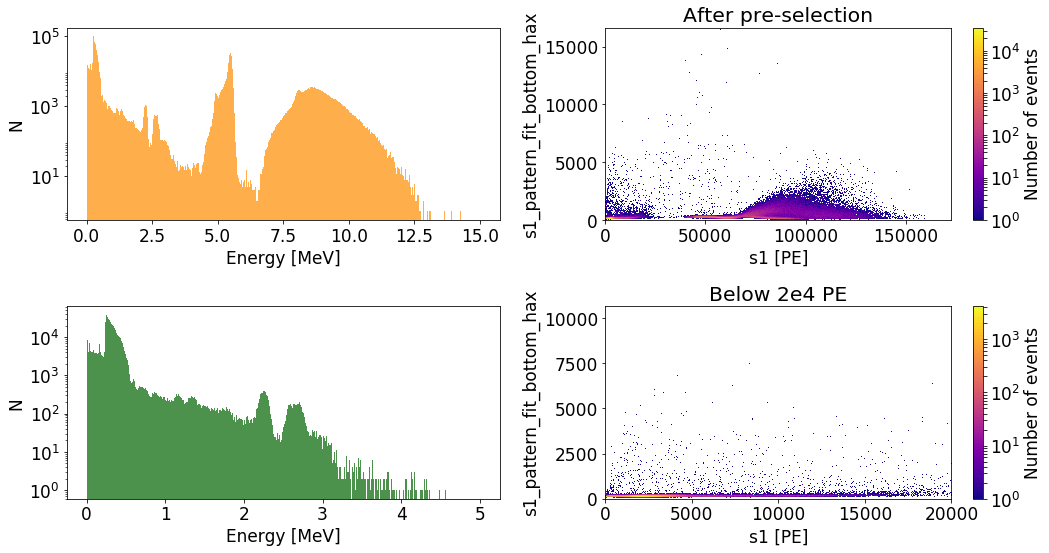

In [7]:
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.hist(data_white['CES']/10**6, bins = (700), 
         range=(0, 15), 
         histtype='bar', color='darkorange',
         alpha = 0.7)
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.subplot(222)
plt.hist2d(data_white['s1'], data_white['s1_pattern_fit_bottom_hax'], bins = (1000, 400), 
           #range=((0,2e4), (0,5e3)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.title('After pre-selection')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.subplot(223)
plt.hist(data['CES']/10**6, bins = (700), 
         range=(0, 5), 
         histtype='bar', color='darkgreen',
         alpha = 0.7)
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.subplot(224)
plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (1000, 400), 
           #range=((0,2e4), (0,5e3)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.title('Below 2e4 PE')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')


plt.tight_layout()
plt.show()

### Cut definition 

In [8]:
def S1PatternLikelihoodProfile(x, a, b, c, d, e):
    return a + b*pow(x, 0.5) + c*x + d*pow(x, 1.5) + e*pow(x, 2)

In [9]:
def S1PatternLikelihoodProfile_v2(x, a, b, d):
    return a + b*pow(x, 0.5) + d*pow(x, 1.5)

In [10]:
def poly5(x, p0, p1, p2, p3, p4, p5):
    return p0 + p1 * x + p2 * x**2 + p3 * x**3 + p4 * x**4 + p5 * x**5  

def inv_poly(x, p0, p1):
    return p0 / np.sqrt(x) + p1 / x

def fit_func(x, p0, p1, p2, p3, p4, p5, p6, p7):
    return poly5(x, p0, p1, p2, p3, p4, p5) + inv_poly(x, p6, p7)

In [11]:
def poly2(x, p0, p1, p2):
    return p0 + p1 * x + p2 * x**2

In [12]:
def poly3(x, p0, p1, p2, p3):
    return p0 + p1 * x + p2 * x**2 + p3* x**3

In [13]:
def poly4(x, p0, p1, p2, p3, p4):
    return p0 + p1 * x + p2 * x**2 + p3* x**3 + p4*x**4

In [14]:
def poly4_2(x, p0, p1, p2, p4):
    return p0 + p1 * x + p2 * x**2 + p4*x**4

In [15]:
def poly0_5(x, p0, p1, p2, p3):
    return p0 + p1 * x + p2 * x**(0.5) + p3*pow(x, 2)

In [16]:
def poly1_5(x, p0, p1, p2, p3, p4):
    return p0 + p1 * x + p2 * x**(0.5) + p3*pow(x, 2) + p4*pow(x,3)

In [17]:
def poly5(x, p0, p1, p2, p3, p4, p5):
    return p0 + p1 * x + p2 * x**2 + p3 * x**3 + p4 * x**4 + p5 * x**5  

The definition of the cut has been divided into two region: at low-energy has been used the same fucntion of SR1, for the other values a new function has been used in order to follow better the data distribution. The parameter space has been divided in equally spaced slice of $s1$ and, as input for cut profile fitting, the $\mu+3\sigma$ of the normal distribution for each slices has been used.

In [18]:
hist, xbins, ybins = np.histogram2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (3000, 200), 
                                   range=((0,2e4), (0,4500)))
ybins_center = [0.5*(ybins[i]+ybins[i+1]) for i in range(len(ybins)-1)]
xbins_center = [0.5*(xbins[i]+xbins[i+1]) for i in range(len(xbins)-1)]

perc = np.empty(len(xbins_center))
for i in tqdm(range(len(hist))):
    perc[i] = percentile(index = i, hist=hist, ybins=ybins, xbins=xbins, q=0.99, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid, perc_valid = dropNaNforFit(xbins_center, perc)
xbins_center_valid, perc_valid = dropNegforFit(xbins_center_valid, perc_valid)

# perc_valid -> 99% s1 pattern fit in s1 slice
# xbins_center_valid -> correspondent s1 to 99% s1 pattern fit

 82%|████████▏ | 2464/3000 [04:02<00:52, 10.15it/s]/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py:1645: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in true_divide
 85%|████████▌ | 2553/3000 [04:20<00:45,  9.80it/s]/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 3000/3000 [04:57<00:00, 10.09it/s]


(0, 500)

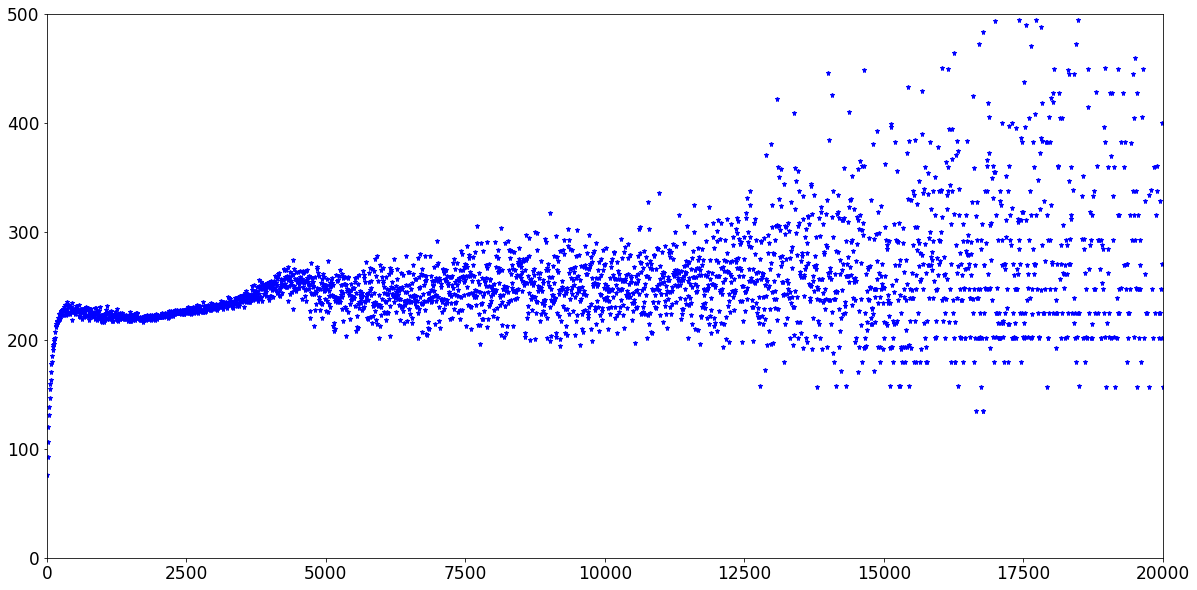

In [19]:
plt.plot(xbins_center_valid, perc_valid, 'b*', lw=2, ms=5)

plt.xlim(0,2e4)
plt.ylim(0,500)

## S1 Pattern Likelihood

[-17.384885, 24.894875, 2.794984, -0.237268, 0.005549] 

 [ -5.02982285e+00   2.70617850e+01  -6.85164479e-01  -1.63572624e-02
   6.10027892e-04] 

 [[  5.52863223e+01  -1.87104224e+01   2.08512792e+00  -9.40968766e-02
    1.48486707e-03]
 [ -1.87104224e+01   6.65144056e+00  -7.64681662e-01   3.52545043e-02
   -5.65061934e-04]
 [  2.08512792e+00  -7.64681662e-01   8.99801322e-02  -4.22181494e-03
    6.85916539e-05]
 [ -9.40968766e-02   3.52545043e-02  -4.22181494e-03   2.00886213e-04
   -3.30094567e-06]
 [  1.48486707e-03  -5.65061934e-04   6.85916539e-05  -3.30094567e-06
    5.47538784e-08]]


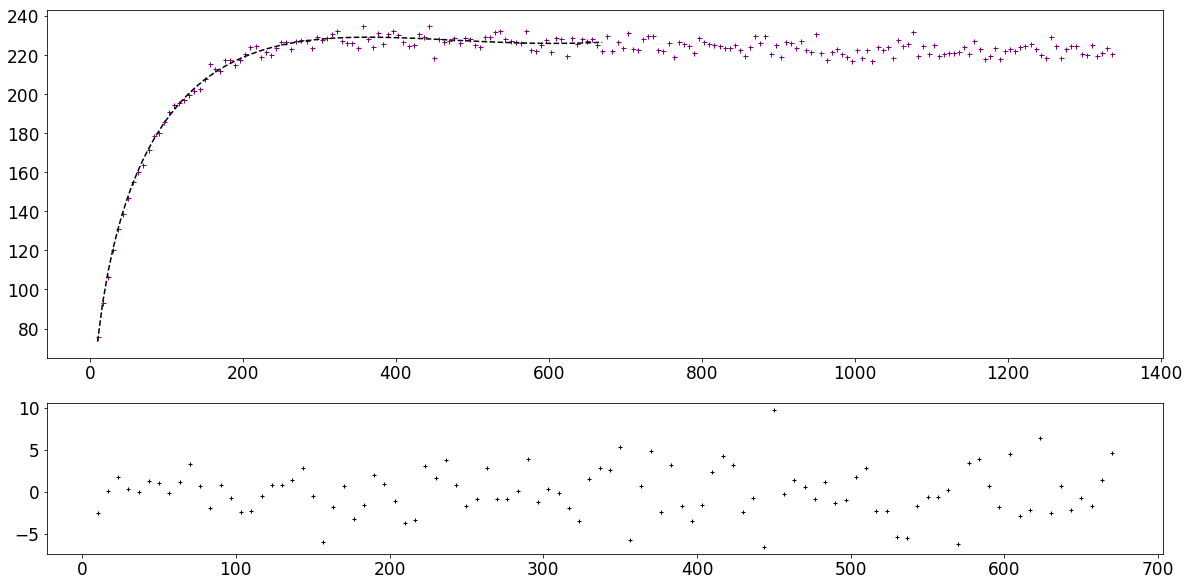

In [20]:
init_old = [-17.384885, 24.894875, 2.794984, -0.237268, 0.005549]

popt_oldV, pcov_oldV = curve_fit(S1PatternLikelihoodProfile, xbins_center_valid[:100], perc_valid[:100], p0=init_old)
print(init_old, '\n\n', popt_oldV ,'\n\n', pcov_oldV)

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])
plt.plot(xbins_center_valid[:200], perc_valid[:200], '+', ms=5, c='purple')

plt.plot(xbins_center_valid[:100], S1PatternLikelihoodProfile(xbins_center_valid[:100], *popt_oldV), 'k--')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid[:100], S1PatternLikelihoodProfile(xbins_center_valid[:100], *popt_oldV)-perc_valid[:100], 'k+', ms=4)

## S1 Pattern Likelihood_v2

[53.3851979, 4.18329309, -0.0247086998, 8.22116191e-05, -1.40534523e-07, 9.50129624e-11] 

 [  6.54334697e+01   2.00452450e+00  -1.01010998e-02   2.54102859e-05
  -3.13600932e-08   1.50359464e-11] 

 [[  5.46651137e+00  -1.40947434e-01   1.11213364e-03  -3.70812454e-06
    5.49950265e-09  -2.99201963e-12]
 [ -1.40947434e-01   4.49168755e-03  -3.88660299e-05   1.36484392e-07
   -2.09264234e-10   1.16517820e-13]
 [  1.11213364e-03  -3.88660299e-05   3.55435912e-07  -1.29408362e-09
    2.03504932e-12  -1.15451997e-15]
 [ -3.70812454e-06   1.36484392e-07  -1.29408362e-09   4.83442373e-12
   -7.74945379e-15   4.46175758e-18]
 [  5.49950265e-09  -2.09264234e-10   2.03504932e-12  -7.74945379e-15
    1.26079630e-17  -7.34531301e-21]
 [ -2.99201963e-12   1.16517820e-13  -1.15451997e-15   4.46175758e-18
   -7.34531301e-21   4.32077233e-24]]


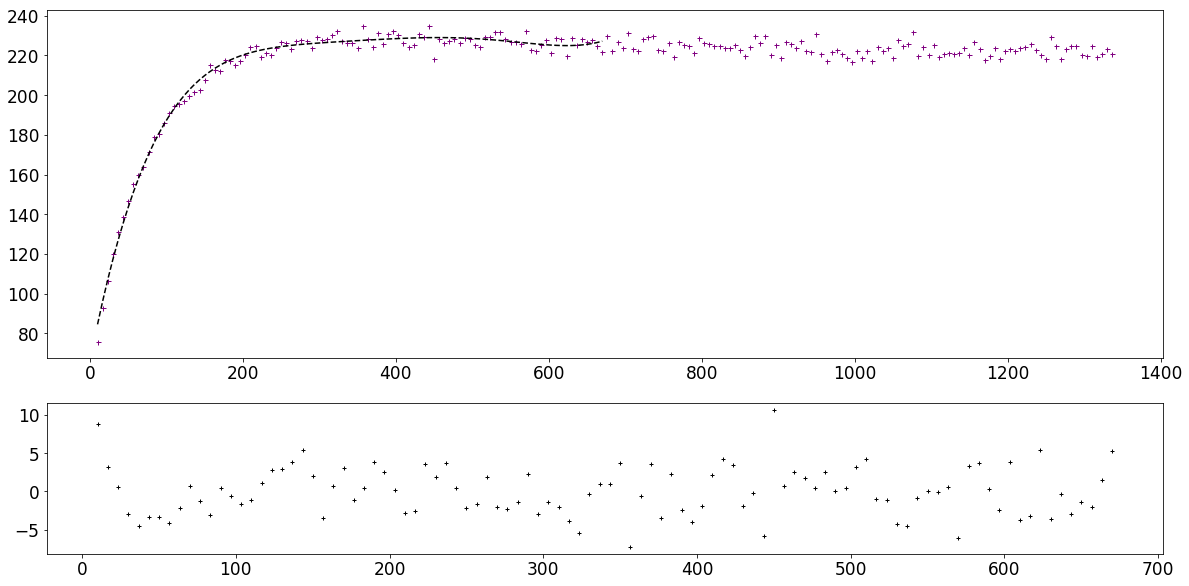

In [21]:
init_old_v2 = [5.33851979e+01,   4.18329309e+00,  -2.47086998e-02,   8.22116191e-05,
  -1.40534523e-07,   9.50129624e-11]

popt_oldV_v2, pcov_oldV_v2 = curve_fit(poly5, xbins_center_valid[:100], perc_valid[:100], p0=init_old_v2)
print(init_old_v2, '\n\n', popt_oldV_v2 ,'\n\n', pcov_oldV_v2)

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])
plt.plot(xbins_center_valid[:200], perc_valid[:200], '+', ms=5, c='purple')

plt.plot(xbins_center_valid[:100], poly5(xbins_center_valid[:100], *popt_oldV_v2), 'k--')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid[:100], poly5(xbins_center_valid[:100], *popt_oldV_v2)-perc_valid[:100], 'k+', ms=4)

## poly_0_5

[-26.5171595, -1.11018687, 42.406849, 0.0002302996] 

 [  1.42179172e+02  -9.78127161e-02   5.48584436e+00   8.92742745e-06] 

 [[  1.27973330e+01   1.70034408e-02  -9.36524196e-01  -1.31951164e-06]
 [  1.70034408e-02   2.95212158e-05  -1.47313975e-03  -2.56052466e-09]
 [ -9.36524196e-01  -1.47313975e-03   7.64060641e-02   1.21952663e-07]
 [ -1.31951164e-06  -2.56052466e-09   1.21952663e-07   2.36384481e-13]]


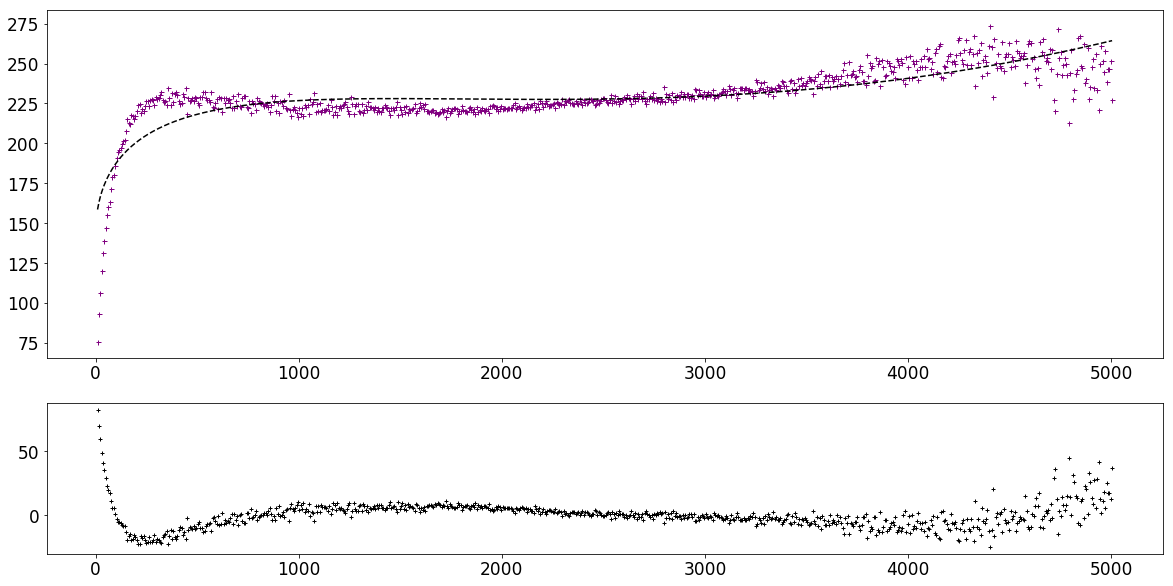

In [22]:
init_poly0_5 = [-2.65171595e+01,  -1.11018687e+00,   4.24068490e+01,   2.30299600e-04]

popt_poly0_5, pcov_poly0_5 = curve_fit(poly0_5, xbins_center_valid[:750], perc_valid[:750], p0=init_poly0_5)
print(init_poly0_5, '\n\n', popt_poly0_5 ,'\n\n', pcov_poly0_5)

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])
plt.plot(xbins_center_valid[:750], perc_valid[:750], '+', ms=5, c='purple')

plt.plot(xbins_center_valid[:750], poly0_5(xbins_center_valid[:750], *popt_poly0_5), 'k--')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid[:750], poly0_5(xbins_center_valid[:750], *popt_poly0_5)-perc_valid[:750], 'k+', ms=4)
#plt.ylim(-500,500)


## poly1_5

[-40.6352176, -1.27500704, 45.6361323, 0.000321824075, -8.45318328e-09] 

 [  7.10608942e+01  -3.67283976e-01   1.45425238e+01   7.06213987e-05
  -6.28171454e-09] 

 [[  9.71927924e+00   2.41484262e-02  -9.58601015e-01  -4.49245754e-06
    4.03325041e-10]
 [  2.41484262e-02   7.74444182e-05  -2.79650079e-03  -1.60400070e-08
    1.52822188e-12]
 [ -9.58601015e-01  -2.79650079e-03   1.04817572e-01   5.53543781e-07
   -5.13621221e-11]
 [ -4.49245754e-06  -1.60400070e-08   5.53543781e-07   3.53140591e-12
   -3.49878040e-16]
 [  4.03325041e-10   1.52822188e-12  -5.13621221e-11  -3.49878040e-16
    3.56247769e-20]]


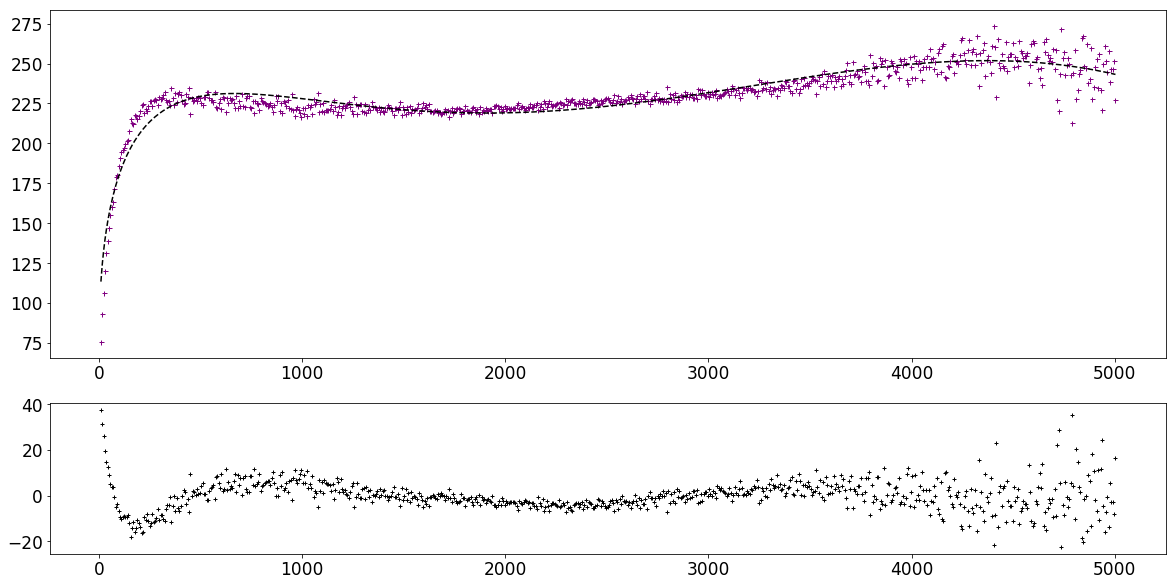

In [23]:
init_poly1_5 = [-4.06352176e+01,  -1.27500704e+00,   4.56361323e+01,  3.21824075e-04,  -8.45318328e-09]

popt_poly1_5, pcov_poly1_5 = curve_fit(poly1_5, xbins_center_valid[:750], perc_valid[:750], p0=init_poly1_5)
print(init_poly1_5, '\n\n', popt_poly1_5 ,'\n\n', pcov_poly1_5)

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])
plt.plot(xbins_center_valid[:750], perc_valid[:750], '+', ms=5, c='purple')

plt.plot(xbins_center_valid[:750], poly1_5(xbins_center_valid[:750], *popt_poly1_5), 'k--')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid[:750], poly1_5(xbins_center_valid[:750], *popt_poly1_5)-perc_valid[:750], 'k+', ms=4)
#plt.ylim(-500,500)


## Poly2

[-46.6563107, 0.0820442923, -1.47469422e-05] 

 [  2.44535889e+02  -4.70671206e-03   4.97309278e-07] 

 [[  3.07842502e+01  -6.22563777e-03   2.63493053e-07]
 [ -6.22563777e-03   1.57202448e-06  -7.32936666e-11]
 [  2.63493053e-07  -7.32936666e-11   3.62233538e-15]]


(-100, 100)

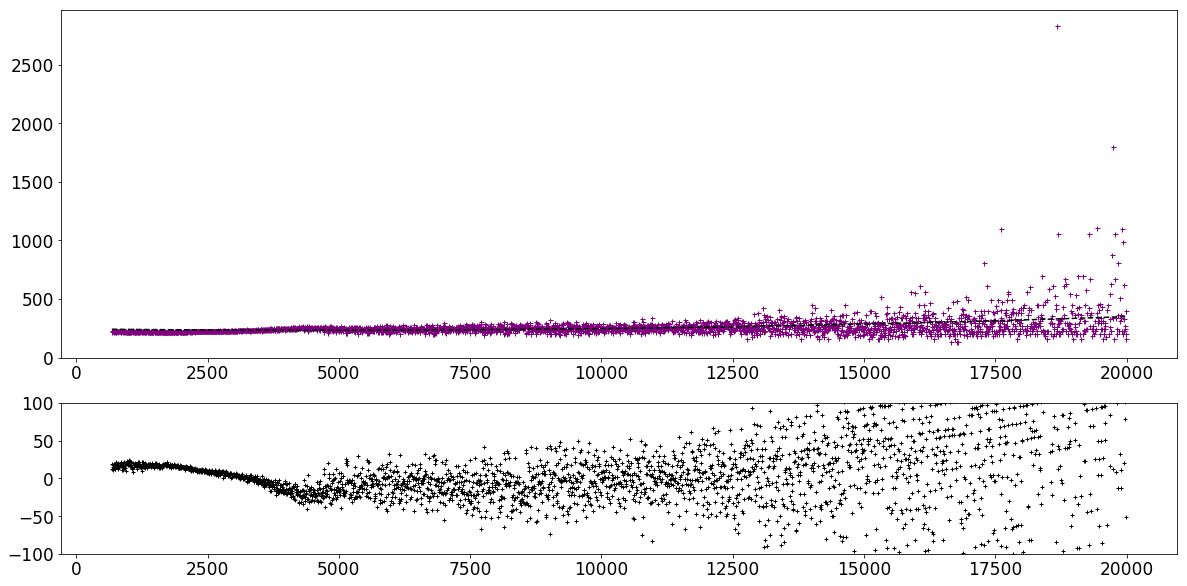

In [24]:
init_poly2 = [-4.66563107e+01, 8.20442923e-02, -1.47469422e-05]

popt_poly2, pcov_poly2 = curve_fit(poly2, xbins_center_valid[100:], perc_valid[100:], p0=init_poly2)
print(init_poly2, '\n\n', popt_poly2, '\n\n', pcov_poly2)

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])
plt.plot(xbins_center_valid[100:], perc_valid[100:], '+', ms=5, c='purple')

plt.plot(xbins_center_valid[100:], poly2(xbins_center_valid[100:], *popt_poly2), 'k--')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid[100:], poly2(xbins_center_valid[100:], *popt_poly2)-perc_valid[100:], 'k+', ms=4)

plt.ylim(-100,100)

# Poly3

[-46.6563107, 0.0820442923, -1.47469422e-05, 1] 

 [  1.94732562e+02   2.06418467e-02  -2.51207789e-06   9.83912470e-11] 

 [[  6.74130459e+01  -2.50843672e-02   2.51326827e-06  -7.37526488e-11]
 [ -2.50843672e-02   1.12070772e-05  -1.21975794e-09   3.75381227e-14]
 [  2.51326827e-06  -1.21975794e-09   1.39846856e-13  -4.45653527e-18]
 [ -7.37526488e-11   3.75381227e-14  -4.45653527e-18   1.45705433e-22]]


(-100, 100)

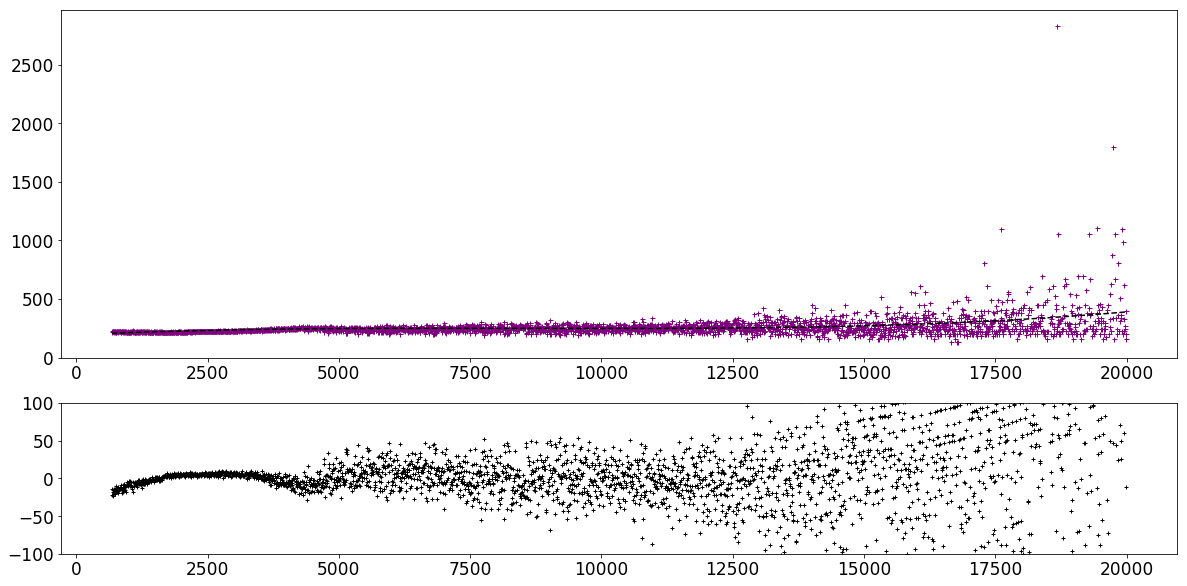

In [25]:
init_poly3 = [-4.66563107e+01, 8.20442923e-02, -1.47469422e-05, 1]

popt_poly3, pcov_poly3 = curve_fit(poly3, xbins_center_valid[100:], perc_valid[100:], p0=init_poly3)
print(init_poly3, '\n\n', popt_poly3, '\n\n', pcov_poly3)

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])
plt.plot(xbins_center_valid[100:], perc_valid[100:], '+', ms=5, c='purple')

plt.plot(xbins_center_valid[100:], poly3(xbins_center_valid[100:], *popt_poly3), 'k--')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid[100:], poly3(xbins_center_valid[100:], *popt_poly3)-perc_valid[100:], 'k+', ms=4)

plt.ylim(-100,100)

## Poly4

[222.939392, -0.00107979833, 1.93289212e-06, -2.31917976e-10, 8.05775242e-15] 

 [  2.22939392e+02  -1.07979833e-03   1.93289212e-06  -2.31917976e-10
   8.05775242e-15] 

 [[  1.41352392e+02  -8.21168688e-02   1.41930897e-05  -9.42080977e-10
    2.11887330e-14]
 [ -8.21168688e-02   5.51550442e-05  -1.02166932e-08   7.06291557e-13
   -1.63171285e-17]
 [  1.41930897e-05  -1.02166932e-08   1.98129951e-12  -1.41316926e-16
    3.33902789e-21]
 [ -9.42080977e-10   7.06291557e-13  -1.41316926e-16   1.03165541e-20
   -2.48125864e-25]
 [  2.11887330e-14  -1.63171285e-17   3.33902789e-21  -2.48125864e-25
    6.05292565e-30]]


(-100, 100)

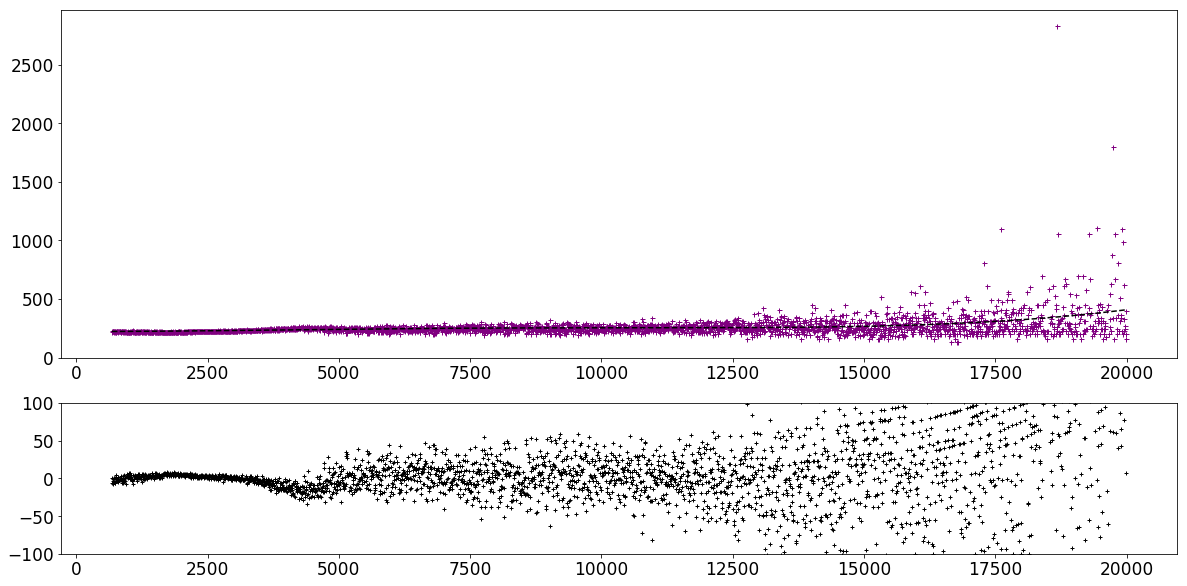

In [26]:
init_poly4 = [2.22939392e+02,  -1.07979833e-03,   1.93289212e-06,  -2.31917976e-10,
   8.05775242e-15]

popt_poly4, pcov_poly4 = curve_fit(poly4, xbins_center_valid[100:], perc_valid[100:], p0=init_poly4)
print(init_poly4, '\n\n', popt_poly4, '\n\n', pcov_poly4)

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])
plt.plot(xbins_center_valid[100:], perc_valid[100:], '+', ms=5, c='purple')

plt.plot(xbins_center_valid[100:], poly4(xbins_center_valid[100:], *popt_poly4), 'k--')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid[100:], poly4(xbins_center_valid[100:], *popt_poly4)-perc_valid[100:], 'k+', ms=4)

plt.ylim(-100,100)

# Poly 4_2

[222.939392, -0.00107979833, -2.31917976e-10, 8.05775242e-15] 

 [  2.01761218e+02   1.47977712e-02  -1.24393831e-06   2.47983950e-15] 

 [[  5.54072825e+01  -1.76466792e-02   1.29033375e-06  -1.47168977e-15]
 [ -1.76466792e-02   6.81117449e-06  -5.42674550e-10   6.71064154e-19]
 [  1.29033375e-06  -5.42674550e-10   4.55982592e-14  -5.99087312e-23]
 [ -1.47168977e-15   6.71064154e-19  -5.99087312e-23   8.53204565e-32]]


(-100, 100)

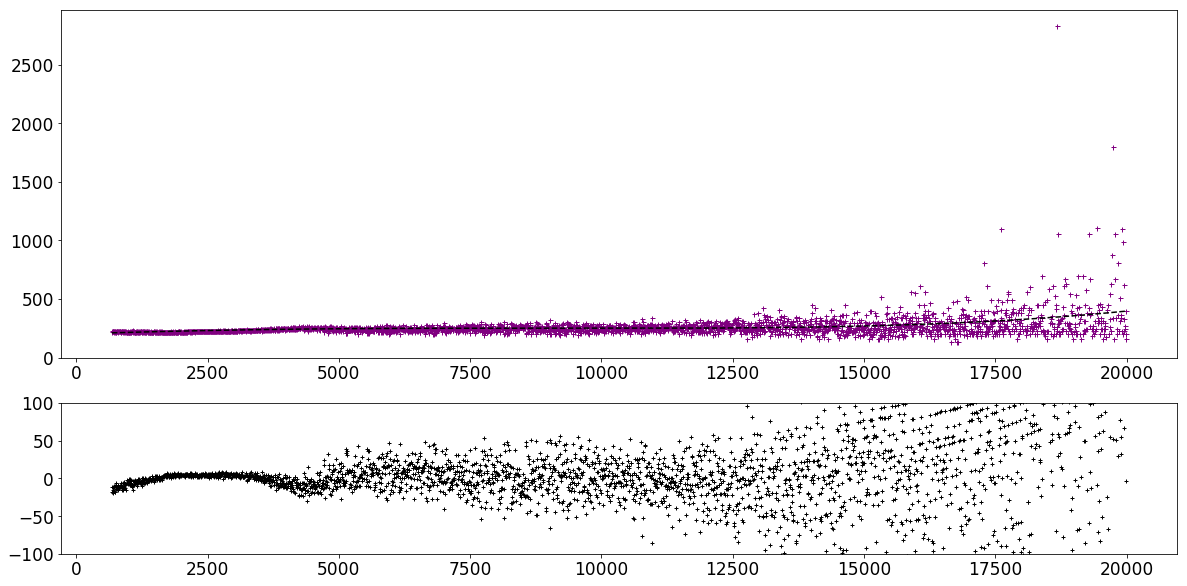

In [27]:
init_poly4_2 = [2.22939392e+02,  -1.07979833e-03, -2.31917976e-10,
   8.05775242e-15]

popt_poly4_2, pcov_poly4_2 = curve_fit(poly4_2, xbins_center_valid[100:], perc_valid[100:], p0=init_poly4_2)
print(init_poly4_2, '\n\n', popt_poly4_2, '\n\n', pcov_poly4_2)

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])
plt.plot(xbins_center_valid[100:], perc_valid[100:], '+', ms=5, c='purple')

plt.plot(xbins_center_valid[100:], poly4_2(xbins_center_valid[100:], *popt_poly4_2), 'k--')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid[100:], poly4_2(xbins_center_valid[100:], *popt_poly4_2)-perc_valid[100:], 'k+', ms=4)

plt.ylim(-100,100)

## poly5

[478.681704, 0.0140005246, -7.12468987e-06, 2.23409109e-09, -2.23585862e-13, 1] 

 [  1.97290713e+02   2.57546099e-02  -6.22358877e-06   7.79609012e-10
  -4.64741565e-14   1.06170578e-18] 

 [[  2.90452748e+02  -2.38190393e-01   6.16457472e-05  -6.82792913e-09
    3.38533882e-13  -6.17903769e-18]
 [ -2.38190393e-01   2.18481539e-04  -5.98688074e-08   6.86459287e-12
   -3.48340835e-16   6.46470578e-21]
 [  6.16457472e-05  -5.98688074e-08   1.70747496e-11  -2.01326187e-15
    1.04261762e-19  -1.96498933e-24]
 [ -6.82792913e-09   6.86459287e-12  -2.01326187e-15   2.42475039e-19
   -1.27642857e-23   2.43688639e-28]
 [  3.38533882e-13  -3.48340835e-16   1.04261762e-19  -1.27642857e-23
    6.80814542e-28  -1.31373817e-32]
 [ -6.17903769e-18   6.46470578e-21  -1.96498933e-24   2.43688639e-28
   -1.31373817e-32   2.55777614e-37]]


(-500, 500)

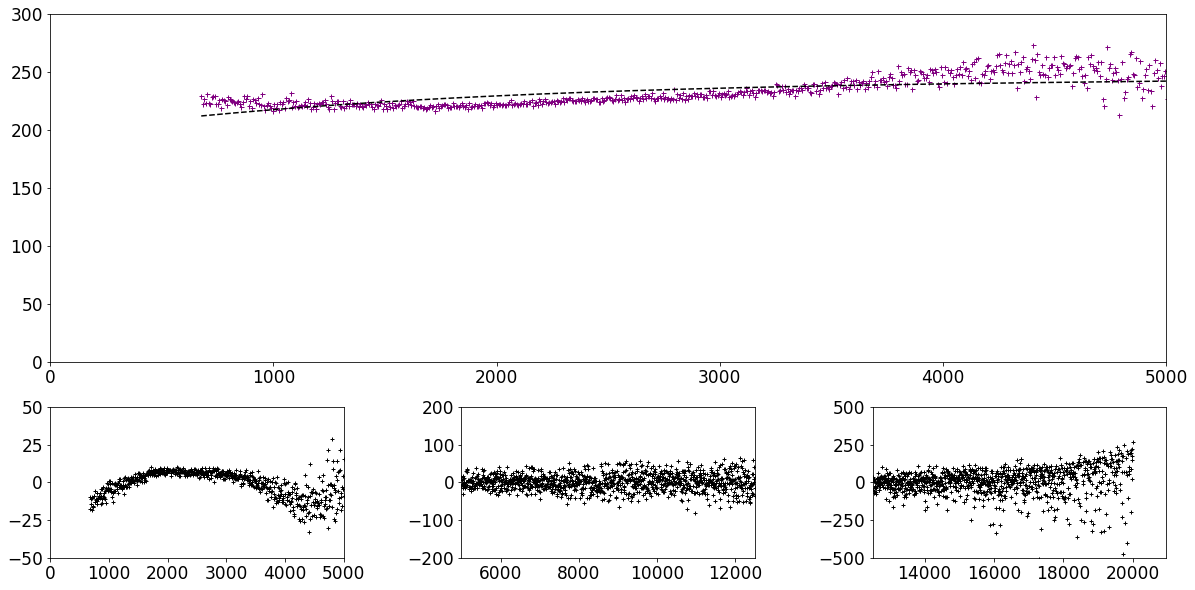

In [28]:
init_poly5 = [4.78681704e+02,  1.40005246e-02, -7.12468987e-06,  2.23409109e-09,
         -2.23585862e-13,1]

popt_poly5, pcov_poly5 = curve_fit(poly5, xbins_center_valid[100:], perc_valid[100:], p0=init_poly5)
print(init_poly5, '\n\n', popt_poly5, '\n\n', pcov_poly5)

grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])
plt.plot(xbins_center_valid[100:], perc_valid[100:], '+', ms=5, c='purple')

plt.plot(xbins_center_valid[100:], poly5(xbins_center_valid[100:], *popt_poly5), 'k--')
plt.xlim(0,5000)
plt.ylim(0,300)
plt.subplot(grid[2, 0]);
plt.plot(xbins_center_valid[100:], poly5(xbins_center_valid[100:], *popt_poly5)-perc_valid[100:], 'k+', ms=4)
plt.xlim(0,5000)
plt.ylim(-50,50)
plt.subplot(grid[2, 1]);
plt.plot(xbins_center_valid[100:], poly5(xbins_center_valid[100:], *popt_poly5)-perc_valid[100:], 'k+', ms=4)
plt.xlim(5000,12500)
plt.ylim(-200,200)
plt.subplot(grid[2, 2]);
plt.plot(xbins_center_valid[100:], poly5(xbins_center_valid[100:], *popt_poly5)-perc_valid[100:], 'k+', ms=4)
plt.xlim(12500)
plt.ylim(-500,500)


## Fit func

[478.681704, 0.0140005246, -7.12468987e-06, 2.23409109e-09, -2.23585862e-13, 7.15271136e-18, -2145.89222, 3169.23133] 

 [ -3.61264720e+02   1.58660986e-01  -2.80209141e-05   2.67830484e-09
  -1.27667086e-13   2.40257032e-18   2.06581921e+04  -2.03486279e+05] 

 [[  2.07102982e+05  -4.37574113e+01   6.72892316e-03  -5.63758721e-07
    2.34974638e-11  -3.81123117e-16  -8.45994290e+06   9.63513740e+07]
 [ -4.37574113e+01   9.53587304e-03  -1.50288803e-06   1.28267761e-10
   -5.42188420e-15   8.89052379e-20   1.75866087e+03  -1.97365028e+04]
 [  6.72892316e-03  -1.50288803e-06   2.42005549e-10  -2.10146449e-14
    9.00555223e-19  -1.49298057e-23  -2.67263729e-01   2.96851244e+00]
 [ -5.63758721e-07   1.28267761e-10  -2.10146449e-14   1.85170609e-18
   -8.03153053e-23   1.34480471e-27   2.22023205e-05  -2.44812197e-04]
 [  2.34974638e-11  -5.42188420e-15   9.00555223e-19  -8.03153053e-23
    3.51947312e-27  -5.94429620e-32  -9.19619758e-10   1.00864468e-08]
 [ -3.81123117e-16   8.89052379e

(-500, 500)

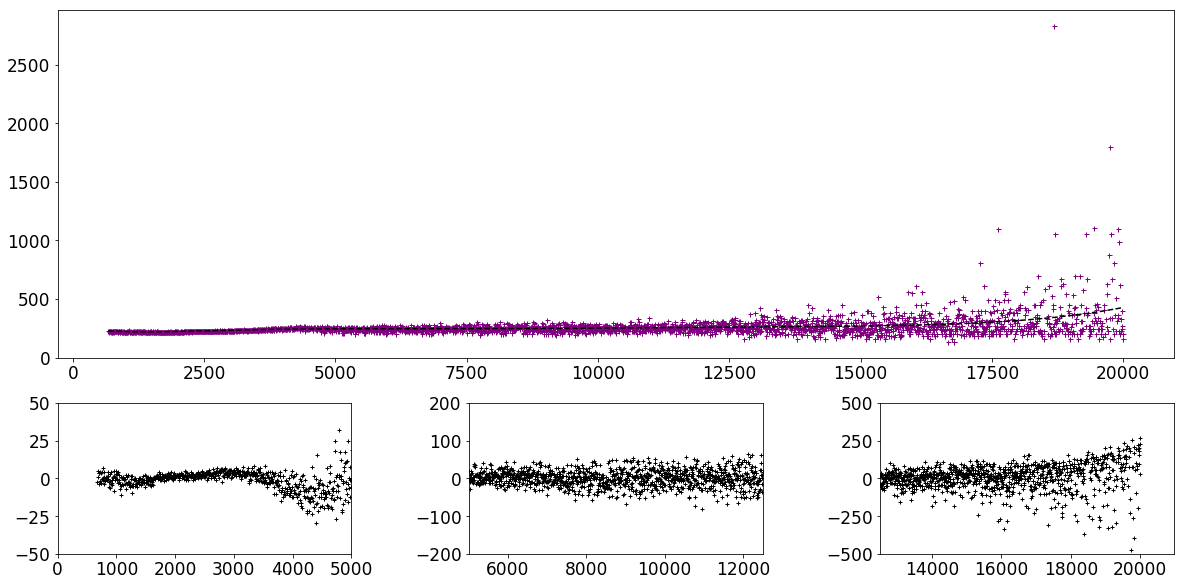

In [29]:
init = [ 4.78681704e+02,  1.40005246e-02, -7.12468987e-06,  2.23409109e-09,
         -2.23585862e-13,  7.15271136e-18, -2.14589222e+03,  3.16923133e+03]

popt, pcov = curve_fit(fit_func, xbins_center_valid[60:], perc_valid[60:], p0=init)
print(init, '\n\n', popt, '\n\n', pcov)
grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])
plt.plot(xbins_center_valid[100:], perc_valid[100:], '+', ms=5, c='purple')

plt.plot(xbins_center_valid[100:], fit_func(xbins_center_valid[100:], *popt), 'k--')

plt.subplot(grid[2, 0]);
plt.plot(xbins_center_valid[100:], fit_func(xbins_center_valid[100:], *popt)-perc_valid[100:], 'k+', ms=4)
plt.xlim(0,5000)
plt.ylim(-50,50)
plt.subplot(grid[2, 1]);
plt.plot(xbins_center_valid[100:], fit_func(xbins_center_valid[100:], *popt)-perc_valid[100:], 'k+', ms=4)
plt.xlim(5000,12500)
plt.ylim(-200,200)
plt.subplot(grid[2, 2]);
plt.plot(xbins_center_valid[100:], fit_func(xbins_center_valid[100:], *popt)-perc_valid[100:], 'k+', ms=4)
plt.xlim(12500)
plt.ylim(-500,500)


# What do I use?

In [30]:
init_1 = [-5.02982285e+00, 2.70617850e+01, -6.85164479e-01, -1.63572624e-02, 6.10027892e-04]

popt_1, pcov_1 = curve_fit(S1PatternLikelihoodProfile, xbins_center_valid[:100], perc_valid[:100], p0=init_1)
print(popt_1 ,'\n\n', pcov_1)

init_2 = [-3.61264720e+02, 1.58660986e-01, -2.80209141e-05, 2.67830484e-09, -1.27667086e-13,
           2.40257032e-18, 2.06581921e+04, -2.03486279e+05]

popt_2, pcov_2 = curve_fit(fit_func, xbins_center_valid[100:], perc_valid[100:], p0=init_2)
print(popt_2, '\n\n', pcov_2)


[ -5.02982285e+00   2.70617850e+01  -6.85164479e-01  -1.63572624e-02
   6.10027892e-04] 

 [[  5.52861659e+01  -1.87103596e+01   2.08512008e+00  -9.40965097e-02
    1.48486122e-03]
 [ -1.87103596e+01   6.65141597e+00  -7.64678640e-01   3.52543637e-02
   -5.65059699e-04]
 [  2.08512008e+00  -7.64678640e-01   8.99797646e-02  -4.22179790e-03
    6.85913834e-05]
 [ -9.40965097e-02   3.52543637e-02  -4.22179790e-03   2.00885425e-04
   -3.30093318e-06]
 [  1.48486122e-03  -5.65059699e-04   6.85913834e-05  -3.30093318e-06
    5.47536807e-08]]
[ -4.06001972e+02   1.67037224e-01  -2.92042860e-05   2.77168490e-09
  -1.31392693e-13   2.46103740e-18   2.26278044e+04  -2.27756290e+05] 

 [[  8.71047469e+05  -1.55880660e+02   2.15851540e-02  -1.68746853e-06
    6.70257407e-11  -1.04965016e-15  -3.99777930e+07   5.24686331e+08]
 [ -1.55880660e+02   2.85119786e-02  -4.02124744e-06   3.18981657e-10
   -1.28161479e-14   2.02550415e-19   7.07402538e+03  -9.18629394e+04]
 [  2.15851540e-02  -4.02124744e-0

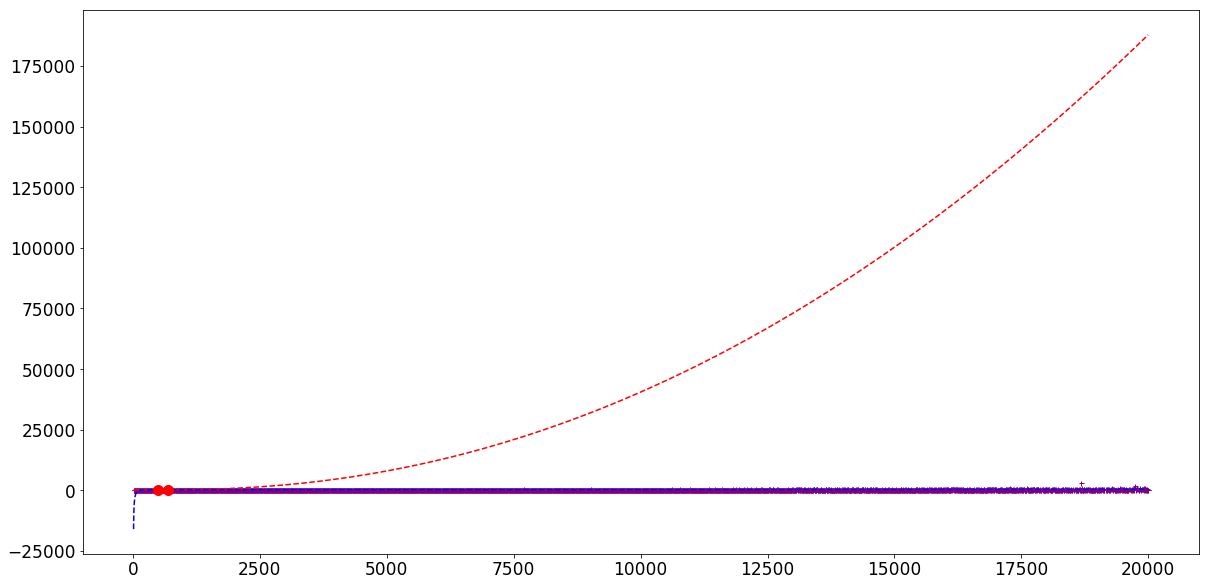

In [31]:
idx = np.argwhere(np.diff(np.sign(S1PatternLikelihoodProfile(xbins_center_valid, *popt_1) - fit_func(xbins_center_valid, *popt_2)))).flatten()


plt.plot(xbins_center_valid[:], perc_valid[:], '+', ms=5, c='purple')

plt.plot(xbins_center_valid[:], S1PatternLikelihoodProfile(xbins_center_valid[:], *popt_1), 'r--')
plt.plot(xbins_center_valid[:], fit_func(xbins_center_valid[:], *popt_2), 'b--')

plt.plot(xbins_center_valid[idx], S1PatternLikelihoodProfile(xbins_center_valid[idx], *popt_1), 'ro' , ms=10)

#plt.xlim(200,1000)
#plt.ylim(200,300)

In [32]:
def basta(x, val):
    if x<val:
        y = S1PatternLikelihoodProfile(x, *popt_1)
    if x>=val:
        y = fit_func(x, *popt_2)
    return y
ybins_center_valid = []
for i in range(len(xbins_center_valid)): 
    ybins_center_valid.append(basta(xbins_center_valid[i], xbins_center_valid[idx[1]]))

(-500, 500)

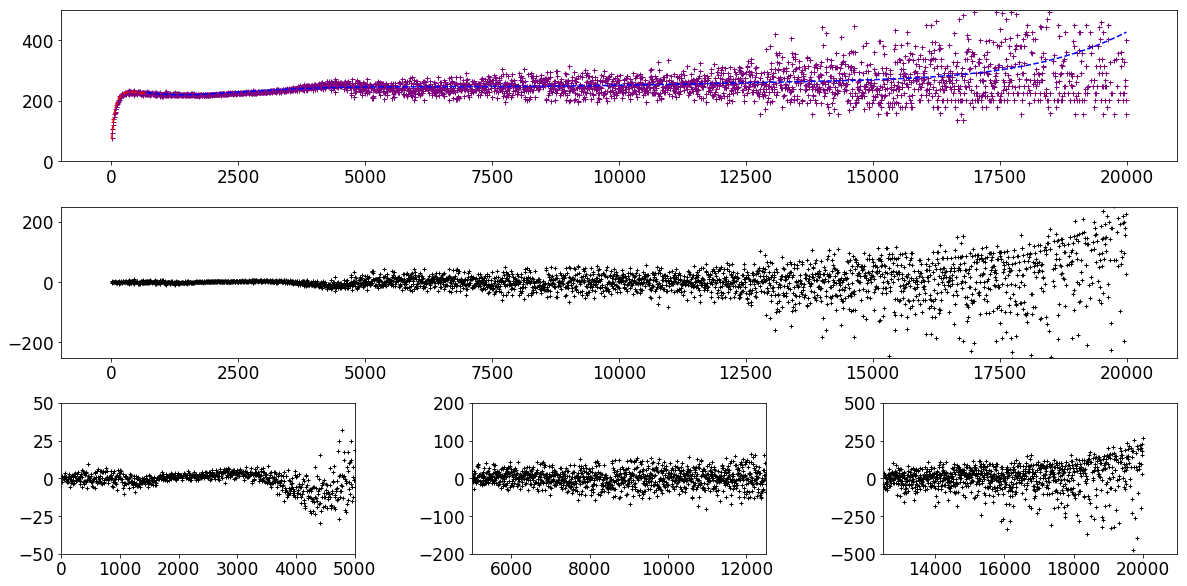

In [33]:
plt.subplot(grid[0, :])
plt.plot(xbins_center_valid, perc_valid, '+', ms=5, c='purple')

plt.plot(xbins_center_valid[:idx[1]], S1PatternLikelihoodProfile(xbins_center_valid[:idx[1]], *popt_1), 'r--')
plt.plot(xbins_center_valid[idx[1]:], fit_func(xbins_center_valid[idx[1]:], *popt_2), 'b--')
plt.ylim(0,500)

plt.subplot(grid[1, :])
plt.plot(xbins_center_valid[:], ybins_center_valid[:]-perc_valid[:], 'k+', ms=4)
plt.ylim(-250,250)

plt.subplot(grid[2, 0]);
plt.plot(xbins_center_valid[:], ybins_center_valid[:]-perc_valid[:], 'k+', ms=4)
plt.xlim(0,5000)
plt.ylim(-50,50)
plt.subplot(grid[2, 1]);
plt.plot(xbins_center_valid[:], ybins_center_valid[:]-perc_valid[:], 'k+', ms=4)
plt.xlim(5000,12500)
plt.ylim(-200,200)
plt.subplot(grid[2, 2]);
plt.plot(xbins_center_valid[:], ybins_center_valid[:]-perc_valid[:], 'k+', ms=4)
plt.xlim(12500)
plt.ylim(-500,500)

(-500, 500)

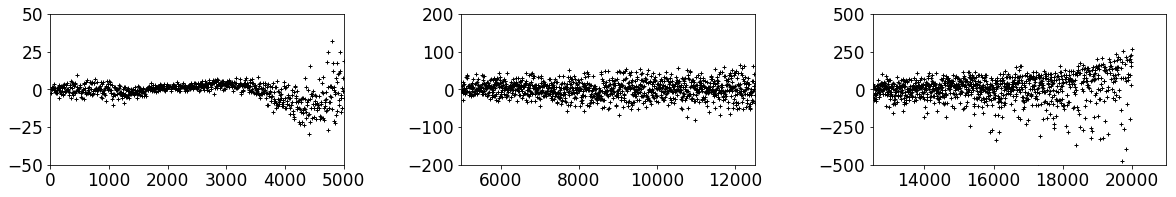

In [34]:
plt.subplot(grid[1, 0]);
plt.plot(xbins_center_valid[:], ybins_center_valid[:]-perc_valid[:], 'k+', ms=4)
plt.xlim(0,5000)
plt.ylim(-50,50)
plt.subplot(grid[1, 1]);
plt.plot(xbins_center_valid[:], ybins_center_valid[:]-perc_valid[:], 'k+', ms=4)
plt.xlim(5000,12500)
plt.ylim(-200,200)
plt.subplot(grid[1, 2]);
plt.plot(xbins_center_valid[:], ybins_center_valid[:]-perc_valid[:], 'k+', ms=4)
plt.xlim(12500)
plt.ylim(-500,500)

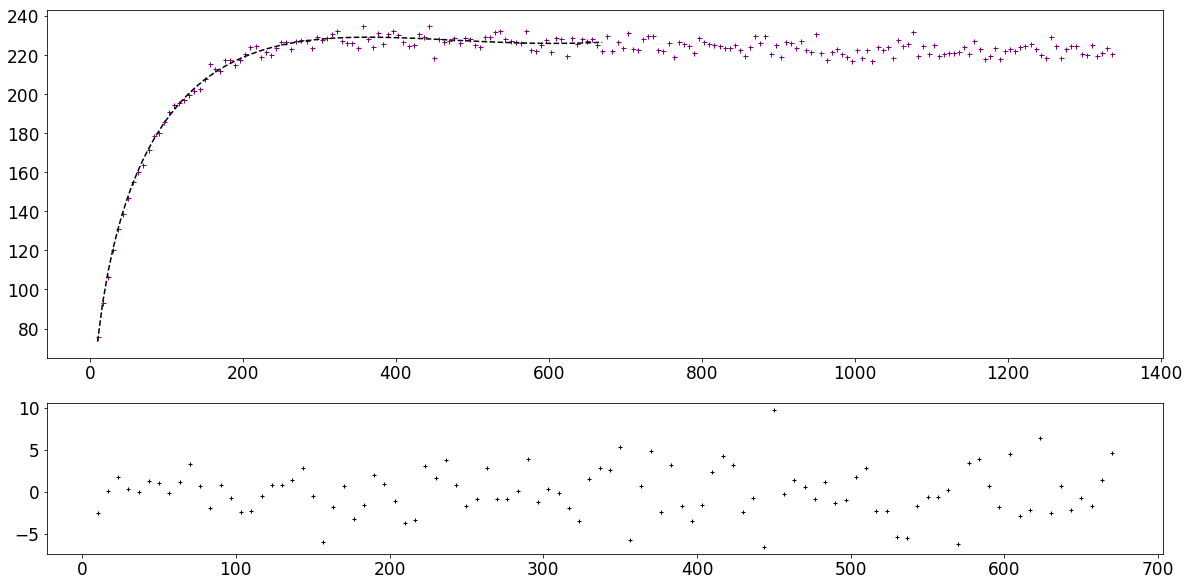

In [35]:
grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])
plt.plot(xbins_center_valid[:200], perc_valid[:200], '+', ms=5, c='purple')

plt.plot(xbins_center_valid[:100], S1PatternLikelihoodProfile(xbins_center_valid[:100], *popt_oldV), 'k--')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid[:100], S1PatternLikelihoodProfile(xbins_center_valid[:100], *popt_oldV)-perc_valid[:100], 'k+', ms=4)

In [36]:
x = np.linspace(0, 2e4, 1e4)

y_shingo = S1PatternLikelihoodProfile(x, *init_old) # s1 patter fit from Shingo cut definition 
y = fit_func(x, *popt) # s1 patter fit from new cut definition fit
y_oldV = S1PatternLikelihoodProfile(x, *popt_oldV) # s1 patter fit from old cut definition fit
y_poly2 = poly2(x, *popt_poly2) # s1 patter fit from old poly2 fit

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in add


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in add


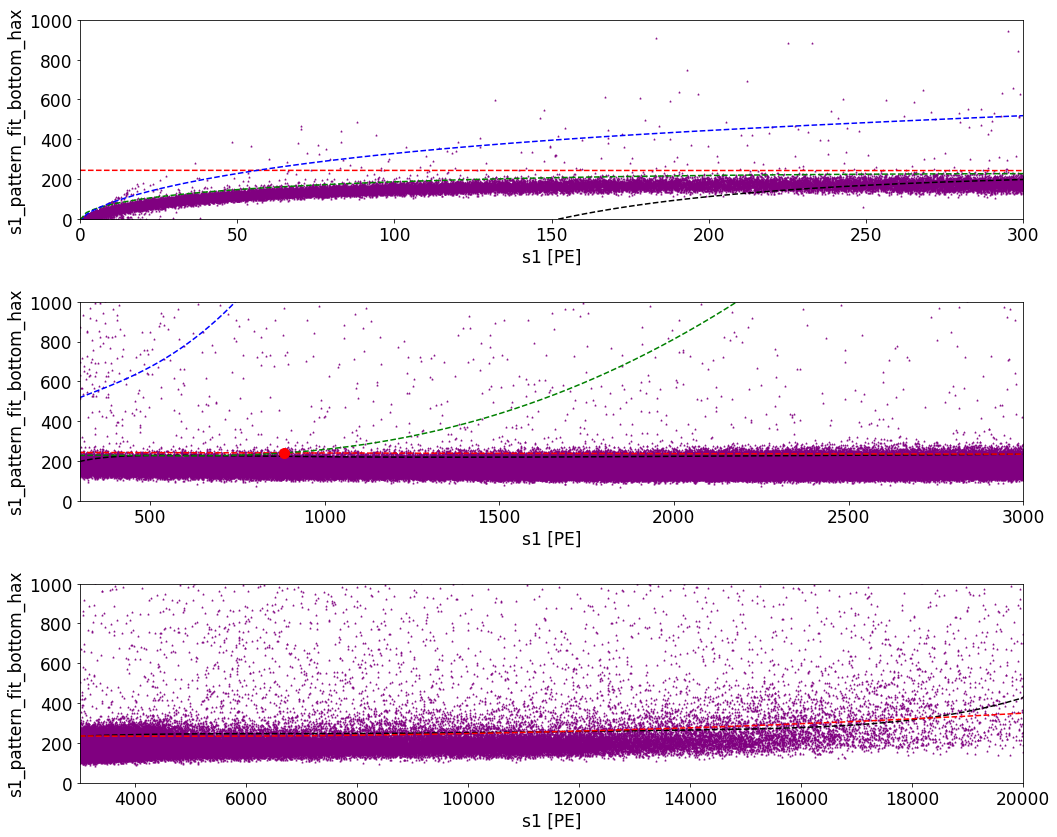

[ 884.08840884] [ 240.68861225]


In [37]:
plt.figure(figsize=(15,12))

idx = np.argwhere(np.diff(np.sign(S1PatternLikelihoodProfile(x, *popt_oldV) - poly2(x, *popt_poly2)))).flatten()

plt.subplot(311)
plt.scatter(data['s1'], data['s1_pattern_fit_bottom_hax'], s=1, marker='^', c='purple')

plt.plot(x, fit_func(x, *popt), 'k--', label = 'New fitted cut')
plt.plot(x, poly2(x, *popt_poly2), 'r--')

plt.plot(x, S1PatternLikelihoodProfile(x, *popt_oldV), 'g--',label = 'Old fitted cut')
plt.plot(x, S1PatternLikelihoodProfile(x, *init_old), 'b--', label = 'SR1 cut')
plt.plot(x[idx], S1PatternLikelihoodProfile(x[idx], *popt_oldV), 'ro' , ms=10)

plt.xlim(0,300)
plt.ylim(0,1000)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.subplot(312)
plt.scatter(data['s1'], data['s1_pattern_fit_bottom_hax'], s=1, marker='^', c='purple')

plt.plot(x, fit_func(x, *popt), 'k--')
plt.plot(x, poly2(x, *popt_poly2), 'r--')

plt.plot(x, S1PatternLikelihoodProfile(x, *popt_oldV), 'g--')
plt.plot(x, S1PatternLikelihoodProfile(x, *init_old), 'b--')
plt.plot(x[idx], S1PatternLikelihoodProfile(x[idx], *popt_oldV), 'ro' , ms=10)

plt.xlim(300,3000)
plt.ylim(0,1000)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.subplot(313)
plt.scatter(data['s1'], data['s1_pattern_fit_bottom_hax'], s=1, marker='^', c='purple')

plt.plot(x, fit_func(x, *popt), 'k--')
plt.plot(x, poly2(x, *popt_poly2), 'r--')

plt.plot(x, S1PatternLikelihoodProfile(x, *popt_oldV), 'g--')
plt.plot(x, S1PatternLikelihoodProfile(x, *init_old), 'b--')
plt.plot(x[idx], S1PatternLikelihoodProfile(x[idx], *popt_oldV), 'ro' , ms=10)

plt.xlim(3000,2e4)
plt.ylim(0,1000)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.tight_layout()
plt.show()

print(x[idx], S1PatternLikelihoodProfile(x[idx], *popt_oldV))

### Cut

In [38]:
def cut(x):
    def poly2(x, p0, p1, p2):
        return p0 + p1 * x + p2 * x**2
       
    def cut_SR1(x, a, b, c, d, e):
        return a + b*pow(x, 0.5) + c*x + d*pow(x, 1.5) + e*pow(x, 2)
    
    params_poly2 = [4.69736375e+02, -3.11861464e-03, 6.26165097e-07]
    params_cut_SR1 = [1.59947241e+01, 1.70047019e+01, 3.04440953e+00, -2.53926414e-01, 5.47698785e-03]
    value = 544.05440544
    y = cut_SR1(x, *params_cut_SR1)*(x<value) + poly2(x, *params_poly2)*(x>=value)
    return y

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


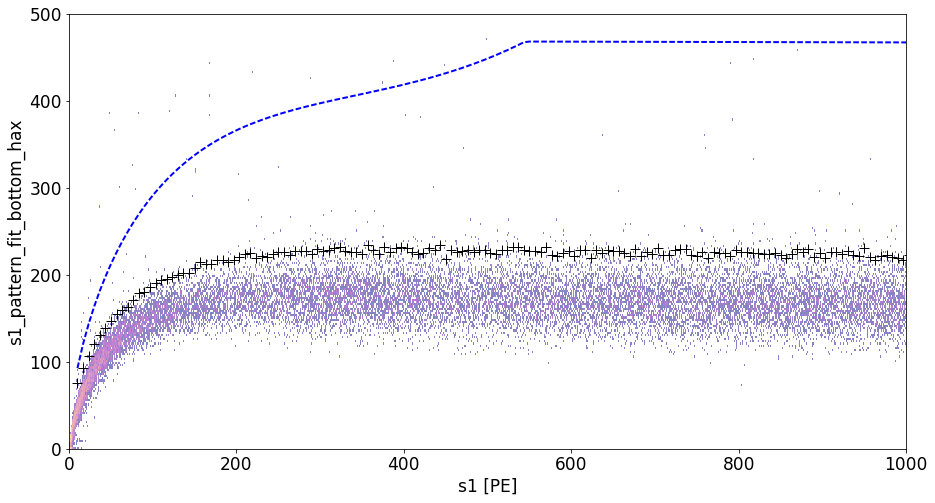

In [39]:
plt.figure(figsize=(15,8))

plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (4000, 200), 
           range=((0,1e3), (0,500)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 0.5)
plt.plot(xbins_center_valid, cut(xbins_center_valid), 'b--', lw=2)
plt.plot(xbins_center_valid, perc_valid, 'k+', ms = 10)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


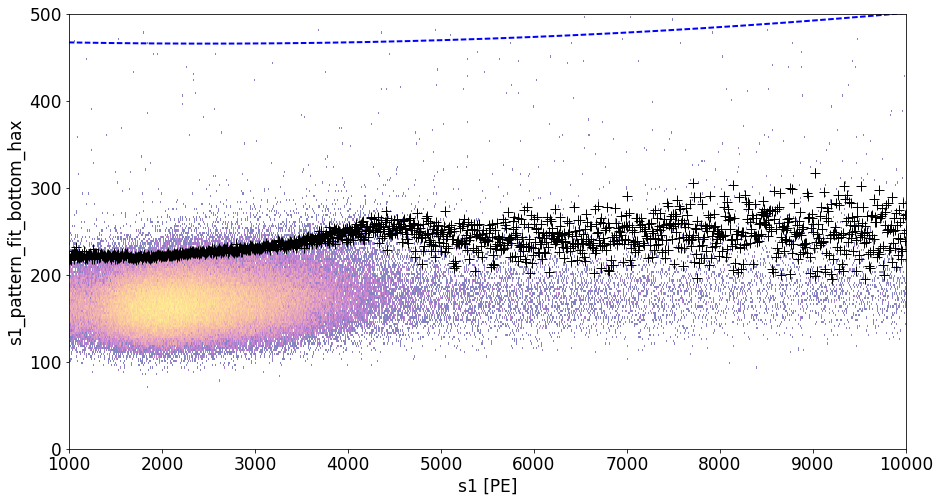

In [40]:
plt.figure(figsize=(15,8))

plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (4000, 200), 
           range=((1e3,1e4), (0,500)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 0.5)
plt.plot(xbins_center_valid, cut(xbins_center_valid), 'b--', lw=2)
plt.plot(xbins_center_valid, perc_valid, 'k+', ms = 10)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


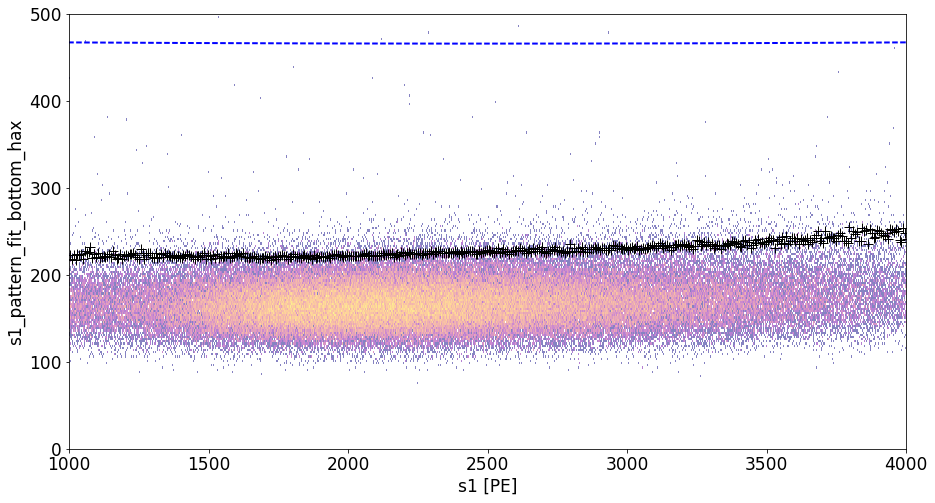

In [41]:
plt.figure(figsize=(15,8))

plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (4000, 200), 
           range=((1e3,4e3), (0,500)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 0.5)
plt.plot(xbins_center_valid, cut(xbins_center_valid), 'b--', lw=2)
plt.plot(xbins_center_valid, perc_valid, 'k+', ms = 10)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


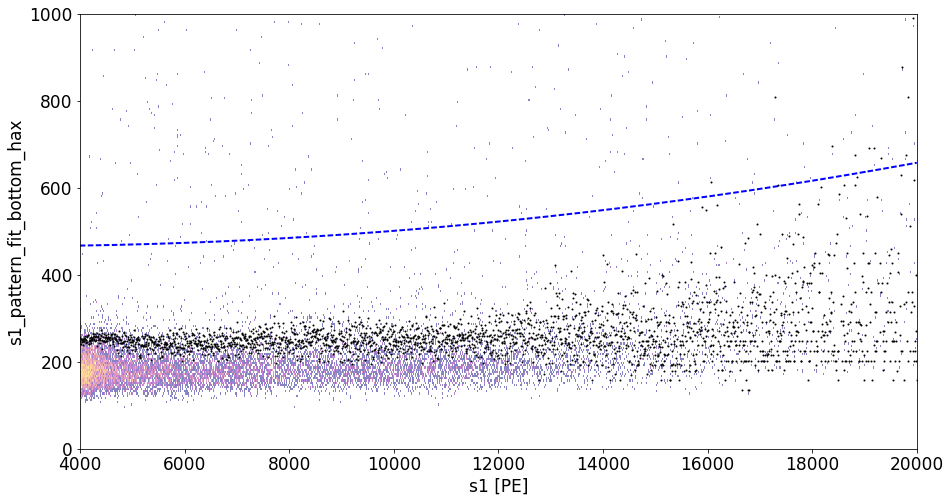

In [42]:
plt.figure(figsize=(15,8))

plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (4000, 200), 
           range=((4e3,2e4), (0,1000)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 0.5)
plt.plot(xbins_center_valid, cut(xbins_center_valid), 'b--', lw=2)
plt.plot(xbins_center_valid, perc_valid, 'ko', ms = 1)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.show()

In [43]:
x_cut = data['s1']
x_cut = x_cut.sort_values()
y_cut = cut(x_cut)

In [44]:
data_cut = data.copy()
data_cut['CutS1PF'] = (((data_cut['s1_pattern_fit_bottom_hax'] < S1PatternLikelihoodProfile(data_cut['s1'], *popt_oldV))*(data_cut['s1']<x[idx][0]))
                      +((data_cut['s1_pattern_fit_bottom_hax'] < poly2(data_cut['s1'], *popt_poly2))*(data_cut['s1']>=x[idx][0])))
data_cut = hax.cuts.selection(data_cut, data_cut['CutS1PF'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Unnamed selection: 21959 rows removed (97.52% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


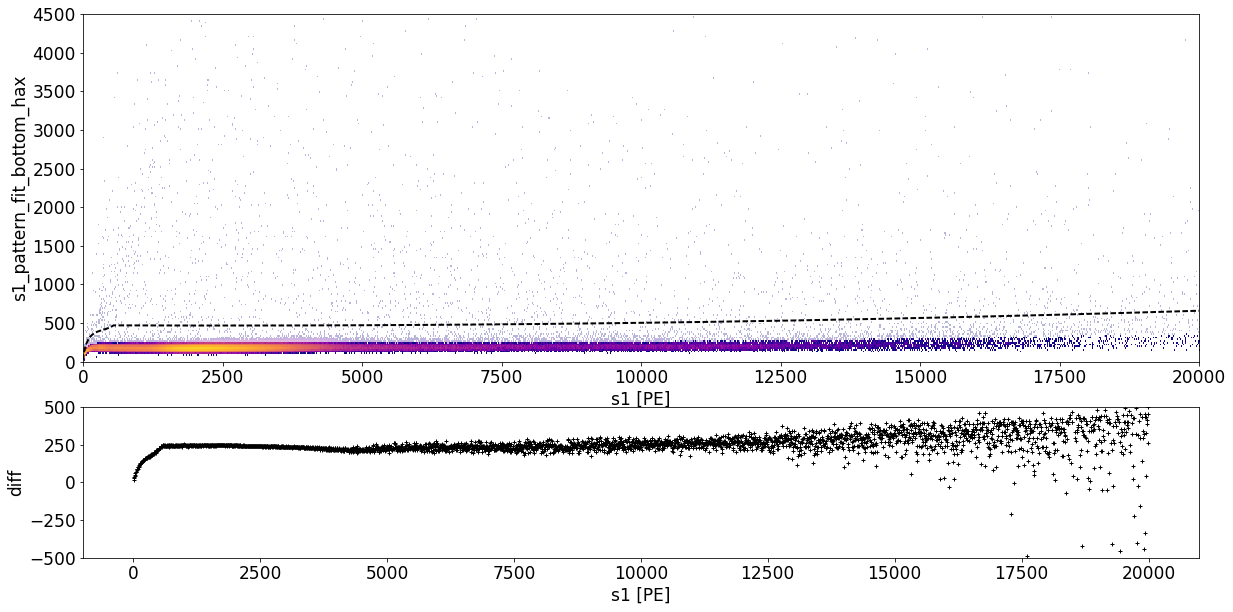

In [45]:
#plt.figure(figsize=(15,8))
grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)

plt.subplot(grid[:2, :])
hist, xbins, ybins, _ = plt.hist2d(data['s1'], data['s1_pattern_fit_bottom_hax'], bins = (2000, 200), 
           range=((0,2e4), (0,4500)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 0.3)
hist_cut, xbins_cut, ybins_cut, _ = plt.hist2d(data_cut['s1'], data_cut['s1_pattern_fit_bottom_hax'], bins = (2000, 200), 
           range=((0,2e4), (0,4500)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.plot(x_cut, y_cut, 'k--', lw=2, ms=4)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_bottom_hax')

plt.subplot(grid[2, :]);
plt.plot(xbins_center_valid, cut(xbins_center_valid)-perc_valid, 'k+', ms=4)
plt.ylim(-500,500)
plt.xlabel('s1 [PE]')
plt.ylabel('diff')

#plt.tight_layout()
plt.show()
hist[np.isnan(hist)] = 0
hist_cut[np.isnan(hist_cut)] = 0

In [46]:
plt.plldata['s1'], cut(data['s1'])-data['s1_pattern_fit_bottom_hax']

AttributeError: 'module' object has no attribute 'plldata'

In [ ]:
bin_centers_acceptance = []
acceptance = []
sigma = []
for i in range(len(xbins_cut)-1):
    bin_centers_acceptance.append((xbins_cut[i+1] + xbins_cut[i])/2.)
    acceptance.append(hist_cut[i].sum()/hist[i].sum())
    sigma.append(np.sqrt(acceptance[i]*(1-acceptance[i])/hist[i].sum()))
    
bin_centers_acceptance = np.array(bin_centers_acceptance)
acceptance = np.array(acceptance)
sigma = np.array(sigma)
acceptance_nan = acceptance[np.logical_not(np.isnan(acceptance))]
sigma_nan = sigma[np.logical_not(np.isnan(sigma))]
acceptance_mean = np.mean(acceptance_nan)
acceptance_median = np.median(acceptance_nan)

print(acceptance_mean, acceptance_median)

In [ ]:
acceptance_mean = np.mean(acceptance_nan[:50])
acceptance_median = np.median(acceptance_nan[:50])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=0, xmax=1e3, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 1000)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

In [ ]:
acceptance_mean = np.mean(acceptance_nan[50:500])
acceptance_median = np.median(acceptance_nan[50:500])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=1e3, xmax=1e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(1e3, 1e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

In [ ]:
acceptance_mean = np.mean(acceptance_nan[500:])
acceptance_median = np.median(acceptance_nan[500:])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=1e4, xmax=2e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(1e4, 2e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

## Check between [0;15e3]

In [ ]:
plt.figure(figsize=(10,7))

acceptance_mean = np.mean(acceptance_nan[:750])
acceptance_median = np.median(acceptance_nan[:750])

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=0, xmax=15e3, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 15e3)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')